### MODEL BUILDING
--- 

In this section, we will develop models to predict customer churn using Decision Trees and Random Forests. Decision Trees are powerful machine learning algorithms that offer a clear and intuitive approach to decision-making by leveraging previous data to guide predictions. Random Forests, on the other hand, build upon Decision Trees by using an ensemble of trees to improve predictive accuracy and control overfitting. We will then compare the performance of both models to determine which performs better.

Since machine learning models require all data to be in numerical form, the first step will be to convert the categorical variables—Gender, Geography, HasCrCard, IsActiveMember, and Churned—into numerical values.

Next, we will create new features to enhance our model. The Number of Products will be categorized into three groups: one, two, and more than two. Similarly, Tenure will be split into two categories: zero and more than zero. Finally, the Balance will be transformed into two categories: zero balance and more than zero

In [1]:
 # Importing the Necessary Libraries
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency ,fisher_exact
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score , recall_score , f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA = pd.read_csv( 'CLEANED DATA.csv' )

In [3]:
 # Setting up the conditions 
condition1 = [( DATA['NumOfProducts'] == 1 ) , ( DATA['NumOfProducts'] == 2 ) , ( DATA['NumOfProducts'] > 2 )]
condition2 = [( DATA['Balance'] == 0 ) , ( DATA['Balance'] > 0 )]

 # Setting the values to change 
values1 = ['One','Two','More_Than_Two']
values2 = ['Zero_Balance' , 'More_Than_Zero']

 # Changing the Data
DATA['Products'] = np.select( condition1 , values1 , default = 'unknown' )
DATA['Account_Balance'] = np.select( condition2 , values2 , default = 'unknown' )

 # Dropping columns 
DATA.drop(columns = 'NumOfProducts', inplace = True )
DATA.drop(columns = 'Balance', inplace = True )

display( DATA )


,CreditScore,Geography,Gender,Age,Tenure,HasCrCard,IsActiveMember,EstimatedSalary,Churned,Products,Account_Balance
0,619,France,Female,42,2,Has,Active,101348.88,Yes,One,Zero_Balance
1,608,Spain,Female,41,1,Doesn't Have,Active,112542.58,No,One,More_Than_Zero
2,502,France,Female,42,8,Has,Not Active,113931.57,Yes,More_Than_Two,More_Than_Zero
3,699,France,Female,39,1,Doesn't Have,Not Active,93826.63,No,Two,Zero_Balance
4,850,Spain,Female,43,2,Has,Active,79084.10,No,One,More_Than_Zero
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,Has,Not Active,96270.64,No,Two,Zero_Balance
9996,516,France,Male,35,10,Has,Active,101699.77,No,One,More_Than_Zero
9997,709,France,Female,36,7,Doesn't Have,Active,42085.58,Yes,One,Zero_Balance
9998,772,Germany,Male,42,3,Has,Not Active,92888.52,Yes,Two,More_Than_Zero


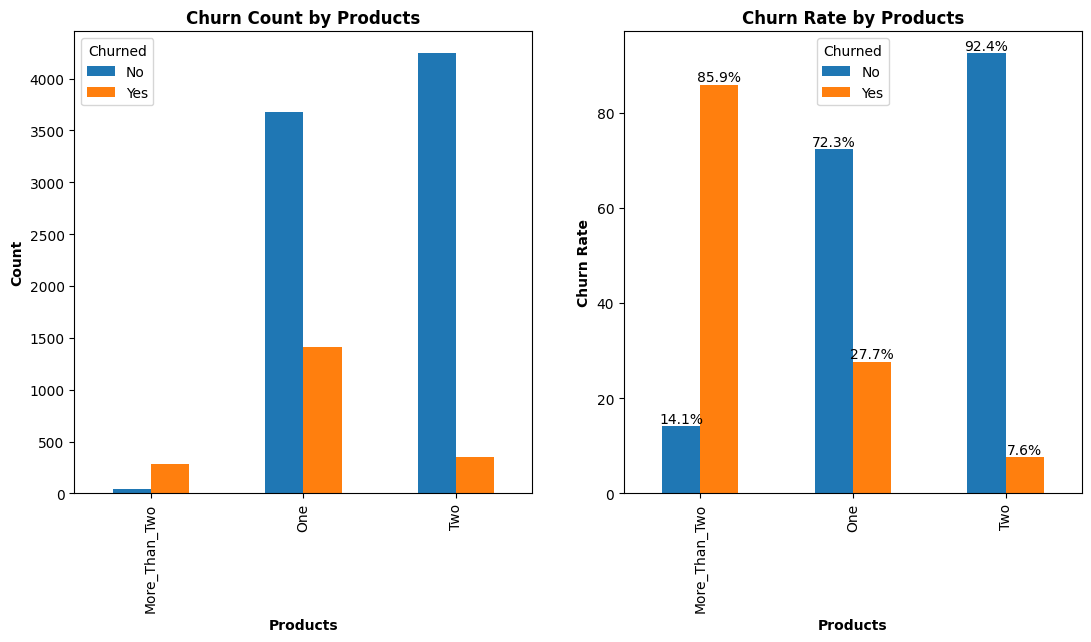

In [4]:
 # visulizing the churn by  products  
crosstab7 = pd.crosstab( DATA['Products'] , DATA['Churned'] ) 
crosstab_7 = pd.crosstab( DATA['Products'] , DATA['Churned'] , normalize = 'index' ) * 100

# Plotting the bar plot with the crosstab result
fig , ax = plt.subplots( 1 , 2 ,figsize = ( 13, 6 ))

crosstab7.plot(kind='bar', stacked=False, ax = ax[0])
crosstab_7.plot(kind='bar', stacked=False, ax = ax[1])

ax[0].set_title( 'Churn Count by Products' , fontweight = 'bold')
ax[0].set_ylabel( 'Count' , fontweight = 'bold')
ax[0].set_xlabel('Products' , fontweight = 'bold')

ax[1].set_title( 'Churn Rate by Products' , fontweight = 'bold')
ax[1].set_ylabel( 'Churn Rate' , fontweight = 'bold')
ax[1].set_xlabel('Products' , fontweight = 'bold')

 # Annotating the bars 
for p in ax[1].patches:
    height = p.get_height()
    
    ax[1].annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),  
                ha='center', va='bottom')  

plt.show()

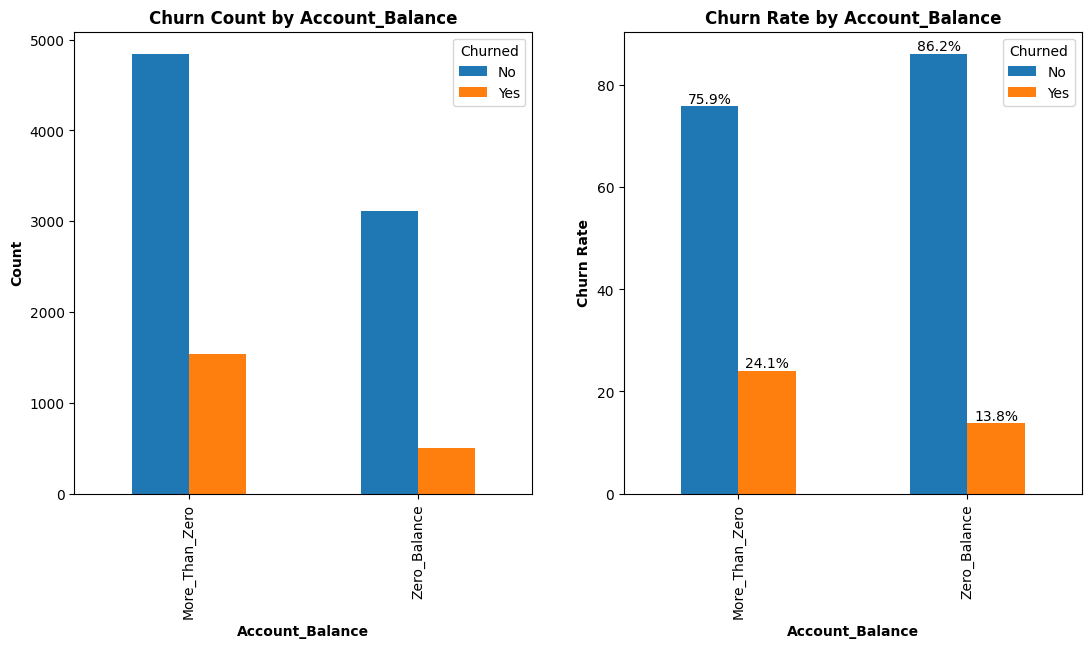

In [5]:
 # Visualizing the churn by Account balance
 # Getting the contingency table 
crosstab8 = pd.crosstab( DATA['Account_Balance'] , DATA['Churned'] ) 
crosstab_8 = pd.crosstab( DATA['Account_Balance'] , DATA['Churned'] , normalize = 'index' ) * 100

# Plotting the bar plot with the crosstab result
fig , ax = plt.subplots( 1 , 2 ,figsize = ( 13, 6 ))

crosstab8.plot(kind='bar', stacked=False, ax = ax[0])
crosstab_8.plot(kind='bar', stacked=False, ax = ax[1])

ax[0].set_title( 'Churn Count by Account_Balance' , fontweight = 'bold')
ax[0].set_ylabel( 'Count' , fontweight = 'bold')
ax[0].set_xlabel('Account_Balance' , fontweight = 'bold')

ax[1].set_title( 'Churn Rate by Account_Balance' , fontweight = 'bold')
ax[1].set_ylabel( 'Churn Rate' , fontweight = 'bold')
ax[1].set_xlabel('Account_Balance' , fontweight = 'bold')

 # Annotating the bars 
for p in ax[1].patches:
    height = p.get_height()
    
    ax[1].annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),  
                ha='center', va='bottom')  

plt.show()

In [ ]:
 # Changing back Churned , IsActiveMember and HasCrCard
DATA["Churned"] = DATA["Churned"].replace({"No" : 0, "Yes" : 1})
DATA["HasCrCard"] = DATA["HasCrCard"].replace({"Doesn't Have" : 0 , "Has" : 1})
DATA["IsActiveMember"] = DATA["IsActiveMember"].replace({"Not Active" : 0 , "Active" : 1})  

To convert the categorical data into numerical format, we will apply one-hot encoding to the relevant features. In this encoding, a value of 1 will represent "true," while 0 will represent "false." For example, if Gender_Female is 1, it indicates that the customer is female.

In [7]:
 # List of columns 
DATA_cat  = ['Account_Balance','Products','Gender','Geography']

 # Getting the dummy variables
DATA = pd.get_dummies( DATA , columns = DATA_cat , dtype = int )


display(DATA.head())


,CreditScore,Age,Tenure,HasCrCard,IsActiveMember,EstimatedSalary,Churned,Account_Balance_More_Than_Zero,Account_Balance_Zero_Balance,Products_More_Than_Two,Products_One,Products_Two,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
0,619,42,2,1,1,101348.88,1,0,1,0,1,0,1,0,1,0,0
1,608,41,1,0,1,112542.58,0,1,0,0,1,0,1,0,0,0,1
2,502,42,8,1,0,113931.57,1,1,0,1,0,0,1,0,1,0,0
3,699,39,1,0,0,93826.63,0,0,1,0,0,1,1,0,1,0,0
4,850,43,2,1,1,79084.10,0,1,0,0,1,0,1,0,0,0,1


From our Exploratory Data Analysis, we observed that some numerical columns are skewed, which may impact the performance of our model. Therefore, we will apply transformations to normalize the data distribution, ensuring improved model performance.

In [8]:
 # Checking the skewed columns
DATA[['Age','CreditScore','EstimatedSalary']].skew().to_frame().rename( columns = {0 : 'Skew'})

,Skew
Age,1.011320
CreditScore,-0.071607
EstimatedSalary,0.002085


We observe that only the Age column exhibits a positive skew. To address this, we will apply a log transformation to the Age column to normalize its distribution.

Skew :  0.182020112559587


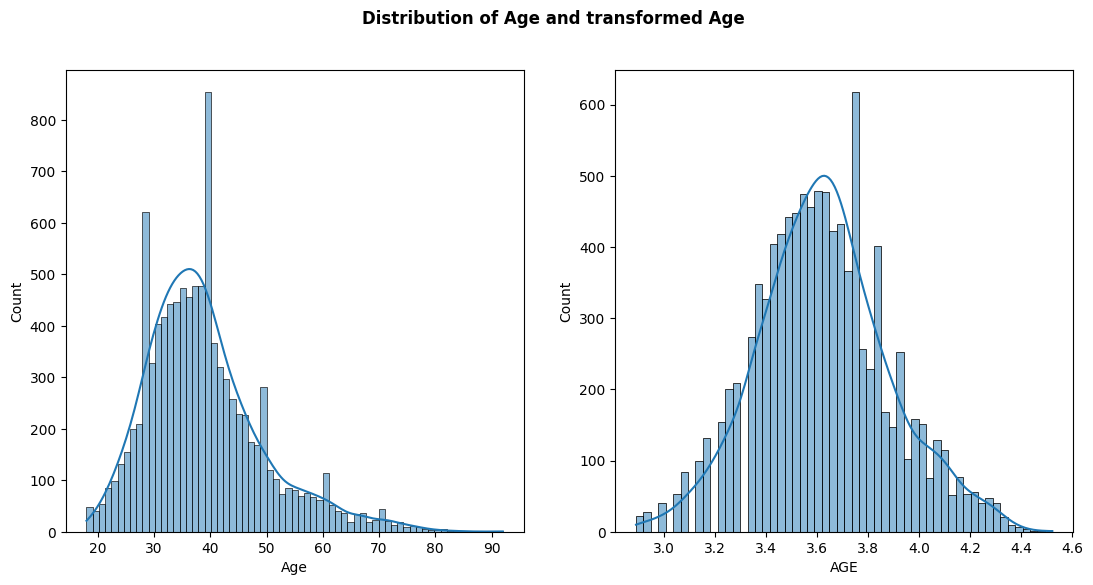

In [9]:
 # log transformation
DATA['AGE'] = np.log( DATA['Age'])

print('Skew : ',DATA['AGE'].skew())

 # Plotting the old age and Tranformed AGE 
fig , ax = plt.subplots( 1 , 2 , figsize = (13,6) )

sns.histplot( x = 'Age' , data = DATA , kde=True , ax = ax[0])
sns.histplot( x = 'AGE' , data = DATA , kde=True , ax = ax[1])

plt.suptitle('Distribution of Age and transformed Age' , fontweight = 'bold')
plt.show()

We can observe from the plot that the symetrical after log transformation. 

In [10]:
 # Dropping the 'Age' Column
DATA.drop(columns = 'Age', inplace = True )

In [11]:
 # Dividing the Data into Dependant and Independent variables 
X = DATA.drop( columns = 'Churned')
y = DATA['Churned']

 # Splitting the data into training and testing data 
X_train,X_test,y_train,y_test = train_test_split( X , y ,test_size = 0.2 , random_state = 21 )

From the Exploratory Data Analysis, we observed that the data is highly imbalanced. To address this issue, we will apply sampling techniques. Specifically, we will use the Synthetic Minority Oversampling Technique (SMOTE), which oversamples the minority class to balance the dataset.

In [12]:
# oversampling the train dataset using SMOTE
smt = SMOTE( random_state = 42 )
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

print('X_Train_Shape : ', X_train_sm.shape , '    y_Train_Shape : ', y_train_sm.shape )

y_train_sm.value_counts().to_frame()

X_Train_Shape :  (12726, 16)     y_Train_Shape :  (12726,)


,count
Churned,
0,6363
1,6363


In [13]:
 # creating the Decision trees 
dtree = DecisionTreeClassifier()
 
 # setting up parameters for the grid search 
grid_par = {"max_depth":[3,4,5,6,7,8,9,10],
              "min_samples_split":[2,3,4,5,6,7,8],
              "min_samples_leaf":[1,2,3,4,5,6,7,8],
              "criterion":["gini","entropy"],
              "splitter":["best","random"],
              "max_features":[None , 'sqrt' ,'log2'],
              "random_state":[0,42]}

# Performing grid search with cross validation 
grid_search = GridSearchCV( estimator= dtree, param_grid = grid_par , cv=5 , scoring='accuracy', n_jobs=-1, verbose=1 )

grid_search.fit( X_train_sm , y_train_sm )

Fitting 5 folds for each of 10752 candidates, totalling 53760 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
                         'random_state': [0, 42],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

After the grid search we will use the best parameters to fit our Decision Tree

In [14]:
 # Fitting the decision tree with the best parameters 
dtree2 = DecisionTreeClassifier( **grid_search.best_params_ )

dtree2.fit( X_train_sm , y_train_sm )

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=3,
                       min_samples_split=7, random_state=0, splitter='random')

we will then perform various performance metrices.

Accuracy on the Training Data :  0.84875 
Accuracy on Testing Data :  0.84 
 Precision Score :  0.6204819277108434 
 Sensitivity Score :  0.515 
 F1 Score :  0.5628415300546448


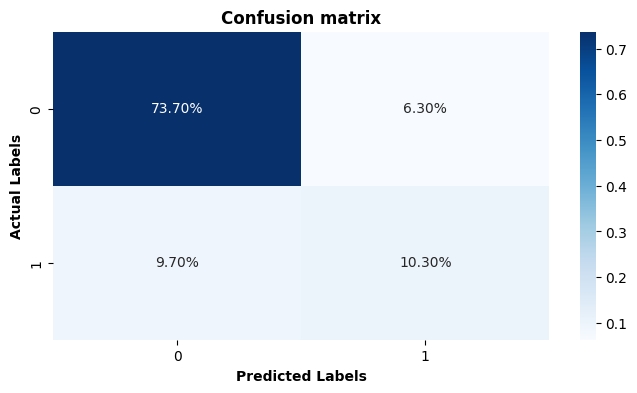

In [15]:
 # Predicting the y_test using the model
y2_pred = dtree2.predict( X_test )

 # Predicting the Training Data
y_train_pred = dtree2.predict( X_train )

 # Getting the accuracy  
print( 'Accuracy on the Training Data : ' , accuracy_score( y_train , y_train_pred ) ,'\n'  'Accuracy on Testing Data : ' ,  accuracy_score( y_test , y2_pred ) , '\n' , 'Precision Score : ' , precision_score( y_test , y2_pred ) , '\n' , 'Sensitivity Score : ' , recall_score( y_test , y2_pred ) , '\n' , 'F1 Score : ' , f1_score( y_test , y2_pred ) )

 # Plotting the confusion matrix 
c_matrix = confusion_matrix( y_test,y2_pred )

plt.figure( figsize = ( 8 , 4 ) )

sns.heatmap( c_matrix / np.sum( c_matrix ) , annot=True, 
            fmt='.2%', cmap='Blues')

plt.title('Confusion matrix', fontweight='bold')
plt.xlabel('Predicted Labels', fontweight='bold')
plt.ylabel('Actual Labels', fontweight='bold')

plt.show()


From the output, we observe that the model achieves an accuracy of 84%, indicating that it correctly predicts 84% of the test data, reflecting strong overall performance.

Additionally, the model’s precision is 62%, meaning that 62% of predicted positive cases (churned customers) are actual positives. The sensitivity (recall) is 52%, indicating that the model correctly identifies 52% of all actual churned customers. The F1 score is 56%, representing a balance between precision and recall.

From the confusion matrix, we observe that the model correctly predicts 73.70% of customers who have not churned as non-churned, while 6.3% of customers who have not churned are incorrectly classified as churned. Similarly, 10.3% of churned customers are correctly predicted as churned, while 9.7% of churned customers are misclassified as non-churned.

The model demonstrates good performance in predicting non-churned customers, but the recall for churned customers is relatively low, indicating that the model misses some actual churned customers. To improve this, further refinement is needed to enhance the model's ability to accurately identify churned customers.


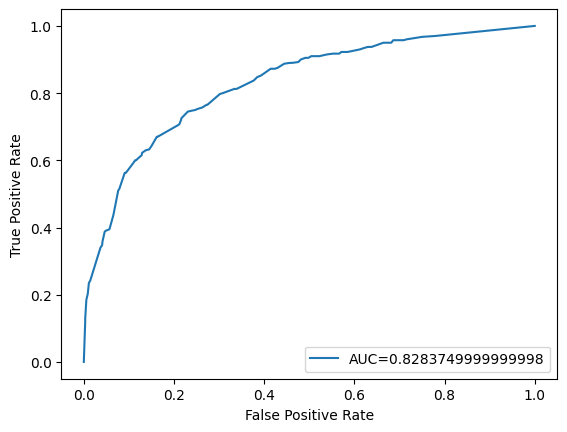

In [16]:
 # Plotting the ROC curve
y_pred_proba = dtree2.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr , tpr , label = "AUC=" + str(auc) )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC (Area Under the Curve) of 82.83% indicates that the model has an 82.8% chance of correctly distinguishing between churned and non-churned customers. An AUC of 0.828 suggests good performance, as it shows that the model can differentiate between churned and non-churned customers with a high degree of accuracy.


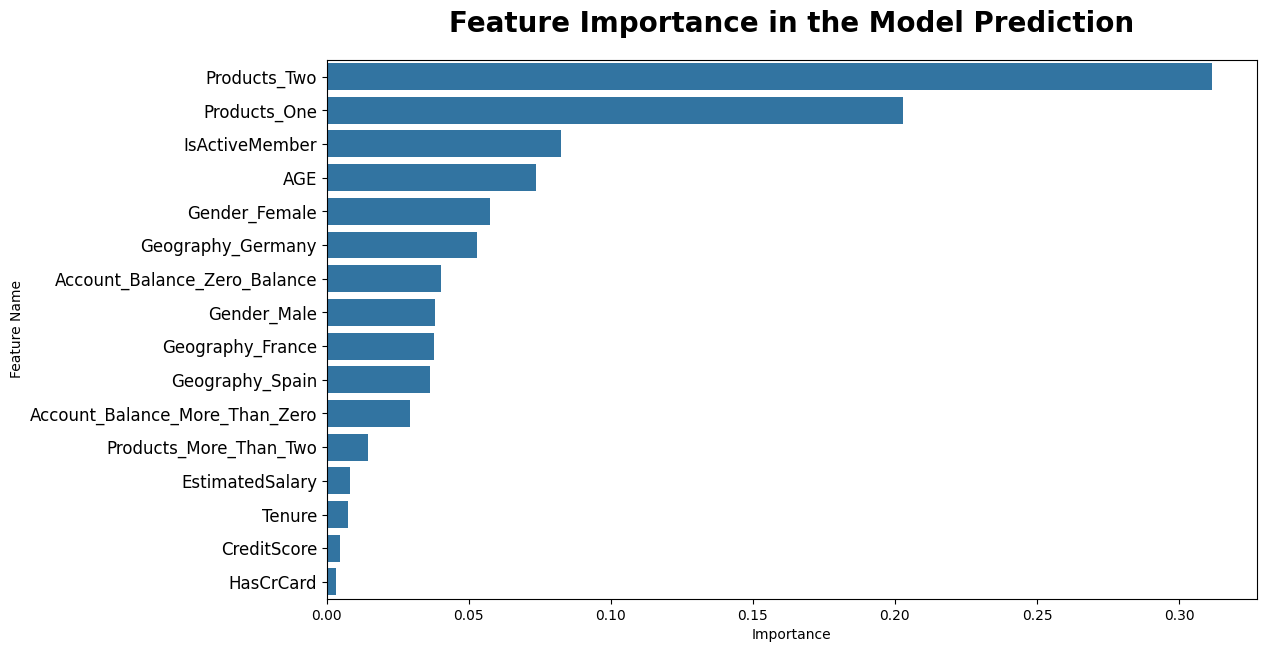

In [17]:
# Get feature importance
importance_df = pd.DataFrame({"Feature Name" : X_train.columns,         # changing into a dataframe 
                       "Importance" : dtree2.feature_importances_})

importances = importance_df.sort_values(by="Importance",ascending=False)

 # plotting the important features
plt.figure(figsize=(12,7))

sns.barplot(x="Importance", y="Feature Name", data = importances )

plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)

plt.yticks(size=12)

plt.show()

From the bar graph, we can conclude that the most important factors influencing customer churn are Number of Products, Age, Active Membership, Geography, Balance, and Gender. On the other hand, the least important features are Tenure and HasCrCard.


#### **Modeling using random forest**

In [ ]:
 # Performing grid search for best parameters 
rf_grid = RandomForestClassifier()

gr_space = {
    'max_depth': [3,5,7,10],
    'n_estimators': [100, 200, 300, 400],
    'max_features': [10, 20, 30 , 40],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy', verbose = 3)
model_grid = grid.fit( X_train_sm , y_train_sm )

In [19]:
# Get the best parameters from the grid search
best_params = model_grid.best_params_
print(f"Best Parameters: {best_params}")

# Get the best estimator (fitted model)
rf_model = model_grid.best_estimator_

Best Parameters: {'max_depth': 7, 'max_features': 30, 'min_samples_leaf': 1, 'n_estimators': 300}


Accuracy on the Training Data :  0.8605 
Accuracy on Testing Data :  0.8635 
 Precision Score :  0.7152542372881356 
 Sensitivity Score :  0.5275 
 F1 Score :  0.6071942446043166


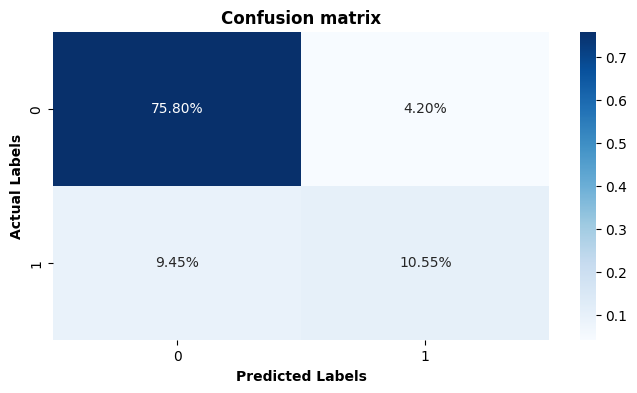

In [22]:
 # Predicting the y_test using the model
y2_pred_1 = rf_model.predict( X_test )

 # Predicting the Training Data
y_train_pred_1 = rf_model.predict( X_train )

 # Getting the accuracy  
print( 'Accuracy on the Training Data : ' , accuracy_score( y_train , y_train_pred_1 ) ,'\n'  'Accuracy on Testing Data : ' ,  accuracy_score( y_test , y2_pred_1 ) , '\n' , 'Precision Score : ' , precision_score( y_test , y2_pred_1 ) , '\n' , 'Sensitivity Score : ' , recall_score( y_test , y2_pred_1 ) , '\n' , 'F1 Score : ' , f1_score( y_test , y2_pred_1 ) )

 # Plotting the confusion matrix 
c_matrix = confusion_matrix( y_test,y2_pred_1 )

plt.figure( figsize = ( 8 , 4 ) )

sns.heatmap( c_matrix / np.sum( c_matrix ) , annot=True, 
            fmt='.2%', cmap='Blues')

plt.title('Confusion matrix', fontweight='bold')
plt.xlabel('Predicted Labels', fontweight='bold')
plt.ylabel('Actual Labels', fontweight='bold')

plt.show()

From the output, we observe that the model achieves an accuracy of 86%, with a precision of 72%, sensitivity (recall) of 52%, and an F1 score of 60%, all of which are relatively higher than the decision tree model's performance.

The confusion matrix shows that the model correctly classifies 76% of non-churned customers, with 4% being incorrectly classified as churned. For churned customers, the model correctly identifies 10.5% as churned, while 9.45% are misclassified as non-churned.

Overall, the model performs well in predicting non-churners but has room for improvement in accurately identifying churners, suggesting a need for further optimization


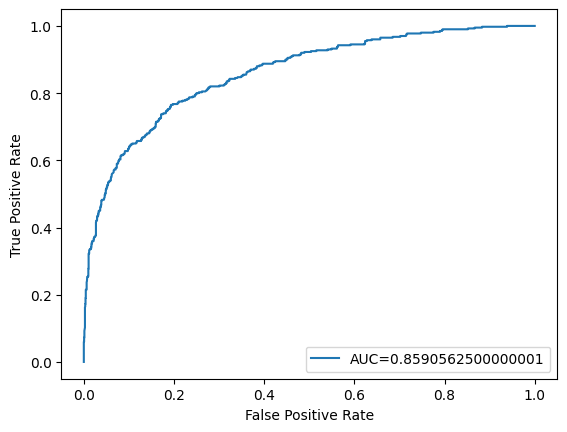

In [23]:
 # Plotting the ROC curve
y_pred_proba_1 = rf_model.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_1)
auc = roc_auc_score(y_test, y_pred_proba_1)

#create ROC curve
plt.plot(fpr , tpr , label = "AUC=" + str(auc) )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC (Area Under the Curve) of 0.8590 indicates that the model has an 85.90% chance of correctly distinguishing between churned and non-churned customers. An AUC of 0.8590 suggests good performance, as it shows that the model can differentiate between churned and non-churned customers with a high degree of accuracy.


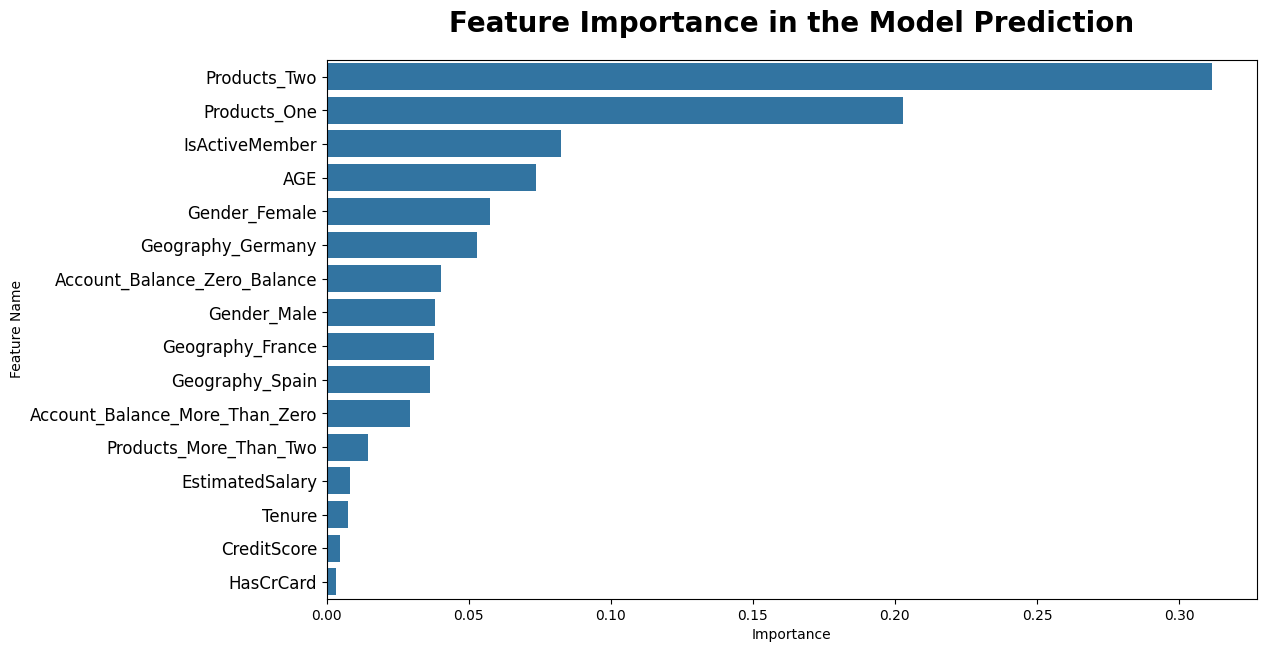

In [24]:
# Get feature importance
importance_df_1 = pd.DataFrame({"Feature Name" : X_train.columns,         # changing into a dataframe 
                       "Importance" : rf_model.feature_importances_})

importances = importance_df.sort_values(by="Importance",ascending=False)

 # plotting the important features
plt.figure(figsize=(12,7))

sns.barplot(x="Importance", y="Feature Name", data = importances )

plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)

plt.yticks(size=12)

plt.show()

The bar graph confirms the same conclusion as the decision tree regarding feature importance. The most significant factors influencing customer churn are Number of Products, Age, Active Membership, Geography, Balance, and Gender. Conversely, the least influential features are Tenure and HasCrCard.

### **CONCLUSION**
The Decision Tree model achieved an accuracy of 84%, with a precision of 62%, recall of 52%, and F1-score of 56%. While the model demonstrated solid overall performance, particularly in predicting non-churned customers (specificity of 73.7%), its ability to detect churned customers was relatively limited, as evidenced by a lower recall rate. The AUC of 0.828 further confirmed moderate discriminatory power. Feature importance analysis from the Decision Tree highlighted the number of products, customer age, active membership, geography, balance, and gender as key predictors of churn.

The Random Forest model, an ensemble learning method, outperformed the Decision Tree in several aspects. It delivered a higher AUC of 0.8590, indicating a stronger ability to distinguish between churned and non-churned customers. While the classification metrics were similar in terms of precision and recall, the Random Forest’s more robust generalization capabilities and reduced overfitting make it a more reliable choice for deployment. Feature importance rankings remained consistent, reaffirming that number of products, age, active membership, geography, balance, and gender are the most influential churn factors, while tenure and credit card status were found to be the least significant.

In conclusion, both models offer valuable insights into churn behavior and customer segmentation. However, the Random Forest model is preferred due to its higher AUC and better generalization. Future improvements could include hyperparameter tuning, incorporating additional features, or exploring other ensemble methods like Gradient Boosting to enhance recall and overall model performance. This analysis can aid in developing targeted retention strategies and improving customer satisfaction in a competitive market.